# From seminar

In [1]:
import numpy as np

from IPython.display import clear_output
from time import sleep

In [2]:
from mdp import has_graphviz, plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values    
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


In [3]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    
    q = 0
    
    for next_state in mdp.get_next_states(state, action):
        q += mdp.get_transition_prob(state, action, next_state) * (
            mdp.get_reward(state, action, next_state) + 
            gamma * state_values[next_state]
        )

    return q

In [4]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0
        
    return max([
        get_action_value(mdp, state_values, state, possible_a, gamma) 
        for possible_a in mdp.get_possible_actions(state)])

In [5]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    possible_actions = mdp.get_possible_actions(state)
    q_values = [
        get_action_value(mdp, state_values, state, possible_a, gamma) 
        for possible_a in possible_actions]
    
    return possible_actions[np.argmax(q_values)]

In [6]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}
    
        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

# HW Part 1: Value iteration convergence

### Find an MDP for which value iteration takes long to converge  (0.5 pts)

When we ran value iteration on the small frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6. Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy? There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

Note: value function must change at least once after iteration >=50, not necessarily change on every iteration till >=50.

### Решение
- залог успеха: на действия с позитивным ревордом даешь крошечные вероятности с большими ревордами

In [8]:
## Last change at iteration 86

transition_probs = {
    's0': {
        'a0': {'s0': 0.79, 's1': 0.2, 's2': 0.01},
        'a1': {'s0': 0.95, 's2': 0.05}
    },
    's1': {
        'a0': {'s0': 0.5, 's1': 0.49, 's2': 0.01},
        'a1': {'s1': 0.9, 's2': 0.1}
    },
    's2': {
        'a0': {'s0': 0.05, 's2': 0.95},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's0': {'a1': {'s2': +5}},
    's2': {'a0': {'s0': +333.429, 's2': -3}, }
}

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
# Feel free to change the initial_state

iter    0   |   diff: 13.82145   |   V(start): 0.250 
0
    policy=array(['a1', 'a0', 'a0'], dtype='<U2')
new_policy=array(['a1', 'a1', 'a0'], dtype='<U2')
N actions changed = 1 

iter    0   |   diff: 11.82859   |   V(start): 1.086 
iter    0   |   diff: 10.15105   |   V(start): 2.333 
iter    0   |   diff: 8.73526   |   V(start): 3.855 
iter    0   |   diff: 7.53717   |   V(start): 5.550 
iter    0   |   diff: 6.52056   |   V(start): 7.339 
iter    0   |   diff: 5.65556   |   V(start): 9.162 
iter    0   |   diff: 4.91752   |   V(start): 10.974 
iter    0   |   diff: 4.28606   |   V(start): 12.746 
iter    0   |   diff: 3.74428   |   V(start): 14.453 
iter    0   |   diff: 3.27819   |   V(start): 16.081 
iter    0   |   diff: 2.87612   |   V(start): 17.621 
iter    0   |   diff: 2.52837   |   V(start): 19.067 
iter    0   |   diff: 2.22682   |   V(start): 20.417 
iter    0   |   diff: 1.96468   |   V(start): 21.671 
iter    0   |   diff: 1.73625   |   V(start): 22.832 
iter    0   | 

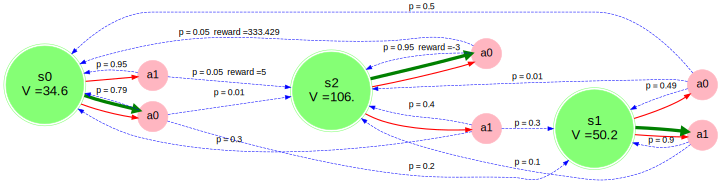

In [9]:
gamma = 0.95

state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

# for i in range(100):
#     print("after iteration %i" % i)
#     state_values = value_iteration(mdp, state_values, num_iter=1)

#     new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
#                            for state in sorted(mdp.get_all_states())])

#     n_changes = (policy != new_policy).sum()
#     print("N actions changed = %i \n" % n_changes)
#     policy = new_policy

for i in range(100):
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    if n_changes > 0:
        print(i)
        print(f'    {policy=}')
        print(f'{new_policy=}')
        print("N actions changed = %i \n" % n_changes)
    policy = new_policy

print('end')
# please ignore iter 0 at each step

if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value, gamma=gamma))

# HW Part 2: Policy iteration

## Policy iteration implementateion (2 pts)

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [10]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

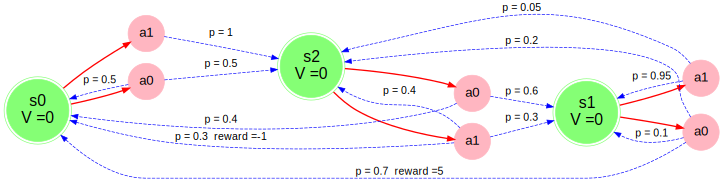

In [11]:
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

<img src="PI_formulae.jpg">

In [12]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    
    ## --------------------------------------------
    ## Calculate A matrix for np.linalg.solve(a, b)
    
    possible_s = {ind: val for ind, val in zip(range(len(mdp.get_all_states())), sorted(mdp.get_all_states()))}
    states_array = np.array(list(possible_s.values()))

    a = np.full((len(possible_s), len(possible_s)), -gamma)

    ## Empty probability matrix to be filled
    p = np.zeros((len(possible_s), len(possible_s)))

    ## Fill probability matrix for current policy
    for s_ind, s_name in possible_s.items():
        if len(mdp.get_possible_actions(s_name)) > 0:
            
            ## For current S check current policy's action
            p_for_s_name_and_policy = mdp.get_next_states(s_name, policy[s_name])
            
            ## For all possible next S' of current S write down their probabilities
            for next_s_name, next_val in p_for_s_name_and_policy.items():
                p[s_ind][np.argmax([np.array_equal(i, next_s_name) for i in states_array])] += next_val
                # p[s_ind][np.argmax(states_array == next_s_name)] = next_val  ## doesn't work when next_s_name is array

    a = a * p + np.eye(len(possible_s))

    
    ## --------------------------------------------
    ## Calculate B matrix for np.linalg.solve(a, b)
    
    all_rewards = mdp._rewards
    
    ## Empty rewards matrix to be filled
    r = np.zeros((len(possible_s), len(possible_s)))

    ## Fill rewards matrix for current policy
    for s_ind, s_name in possible_s.items():
        if s_name in all_rewards.keys():
            if policy[s_name] in all_rewards[s_name].keys():
            
                ## For current S check current policy's action
                r_for_s_name_and_policy = mdp._rewards[s_name][policy[s_name]]
            
                ## For all possible next S' of current S write down their rewards
                for next_s_name, next_val in r_for_s_name_and_policy.items():
                    r[s_ind][np.argmax([np.array_equal(i, next_s_name) for i in states_array])] += next_val
                    # r[s_ind][np.argmax(states_array == next_s_name)] = next_val  ## doesn't work when next_s_name is array

    b = np.sum(p * r, axis=1)

    
    ## --------------------------------------------
    ## Solve np.linalg.solve(a, b)
    
    return {s_name: solution for s_name, solution in zip(possible_s.values(), np.linalg.solve(a, b))}

In [13]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 6.432568550643525, 's1': 10.086737548964734, 's2': 7.109681029658636}


Once we've got new state values, it's time to update our policy.

In [14]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    return {state: get_optimal_action(mdp, vpi, state, gamma) for state in sorted(mdp.get_all_states())}

In [15]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 'a1', 's1': 'a0', 's2': 'a0'}


__Main loop__

In [16]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    all_states = mdp.get_all_states()
    
    if policy is None:
        # policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in all_states}
        policy = {s: np.random.choice(mdp.get_possible_actions(s)) 
                     if not mdp.is_terminal(s) 
                     else None
                  for s in all_states}
    
    diff = 0
    state_values = compute_vpi(mdp, policy, gamma)
    
    for i in range(num_iter):
        new_policy = compute_new_policy(mdp, state_values, gamma)
        
        new_state_values = compute_vpi(mdp, new_policy, gamma)
        
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in all_states)
        
        print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
        print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
        
        state_values = new_state_values
        policy = new_policy

        if diff < min_difference:
            print("Terminated")
            break
        
    return state_values, policy

__Your PI Results__

policy=None
state_values={'s0': 0, 's1': 0, 's2': 0}


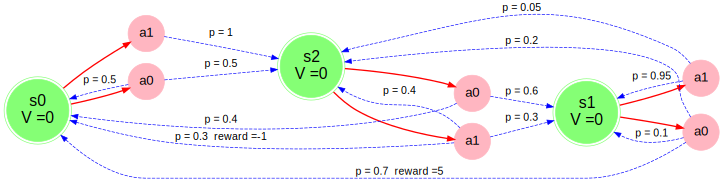

In [17]:
mdp.reset()

# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
min_difference = 1e-4

# policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
policy = None
print(f'{policy=}')
 
if policy is None:
    state_values = {s: 0 for s in mdp.get_all_states()}
else:
    state_values = compute_vpi(mdp, policy, gamma)
    
print(f'{state_values=}')

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

iter    0   |   diff: 9.26773   |   V(s0) = 0.000   V(s1) = -0.000   V(s2) = 0.000
iter    1   |   diff: 2.22765   |   V(s0) = 5.804   V(s1) = 9.268   V(s2) = 7.094
iter    2   |   diff: 0.00000   |   V(s0) = 8.032   V(s1) = 11.172   V(s2) = 8.924
Terminated

Time taken = 0.0031 seconds.

policy={'s0': 'a1', 's1': 'a0', 's2': 'a0'}
state_values={'s0': 8.031919916894896, 's1': 11.171970913211831, 's2': 8.924355463216552}


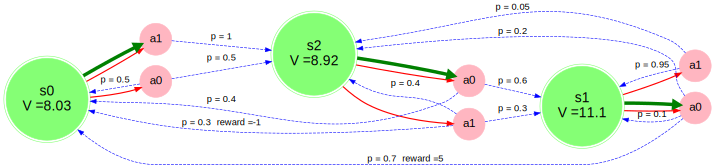

In [18]:
import time

time_1 = time.perf_counter()

state_values, policy = policy_iteration(
    mdp, 
    # policy=policy, 
    gamma=gamma, 
    num_iter=num_iter, 
    min_difference=min_difference)

time_2 = time.perf_counter()

print(f'\nTime taken = {round(time_2 - time_1, 5)} seconds.\n')
print(f'{policy=}')
print(f'{state_values=}')

if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value, gamma=gamma))

### Comparing to VI

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 1.89000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 1.70100   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890
iter    3   |   diff: 1.13542   |   V(s0) = 1.701   V(s1) = 4.184   V(s2) = 2.060
iter    4   |   diff: 0.73024   |   V(s0) = 1.854   V(s1) = 5.319   V(s2) = 2.871
iter    5   |   diff: 0.61135   |   V(s0) = 2.584   V(s1) = 5.664   V(s2) = 3.540
iter    6   |   diff: 0.54664   |   V(s0) = 3.186   V(s1) = 6.275   V(s2) = 3.989
iter    7   |   diff: 0.49198   |   V(s0) = 3.590   V(s1) = 6.790   V(s2) = 4.535
iter    8   |   diff: 0.42210   |   V(s0) = 4.082   V(s1) = 7.189   V(s2) = 4.959
iter    9   |   diff: 0.36513   |   V(s0) = 4.463   V(s1) = 7.611   V(s2) = 5.352
iter   10   |   diff: 0.32862   |   V(s0) = 4.816   V(s1) = 7.960   V(s2) = 5.717
iter   11   |   diff: 0.29262   |   V(s0) = 5.145   V(s1) = 8.280   V(s2) = 6.032
iter   12   |   

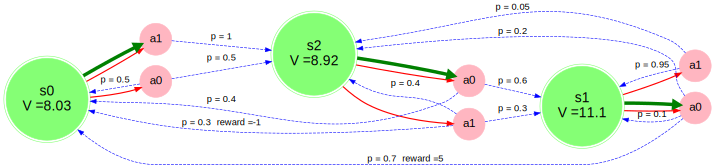

In [19]:
time_1 = time.perf_counter()

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(num_iter):
    # Compute new state values using the functions you defined above.
    new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

time_2 = time.perf_counter()

print(f'\nTime taken = {round(time_2 - time_1, 5)} seconds.\n')
print(f'{state_values=}')

if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value, gamma=gamma))

### Small lake

In [20]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0.1)

#### VI

after iteration 14
iter    0   |   diff: 0.00003   |   V(start): 0.490 


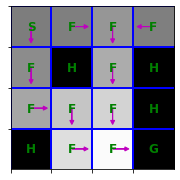

Terminated


In [21]:
mdp.reset()

min_difference = 1e-4

state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(50):
    clear_output(True)
    
    print("after iteration %i" % i)
    new_state_values = value_iteration(mdp, state_values, num_iter=1)
    
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    state_values = new_state_values
    
    draw_policy(mdp, state_values)
    
    sleep(0.15)
    
    if diff < min_difference:
        print("Terminated")
        break
# please ignore iter 0 at each step

#### PI

after iteration 5
iter    0   |   diff: 0.00000   |   V((0, 0)) = 0.490   V((0, 1)) = 0.500   V((0, 2)) = 0.589   V((0, 3)) = 0.500   V((1, 0)) = 0.550   V((1, 1)) = 0.000   V((1, 2)) = 0.672   V((1, 3)) = 0.000   V((2, 0)) = 0.649   V((2, 1)) = 0.770   V((2, 2)) = 0.830   V((2, 3)) = 0.000   V((3, 0)) = 0.000   V((3, 1)) = 0.869   V((3, 2)) = 0.982   V((3, 3)) = 0.000
Terminated


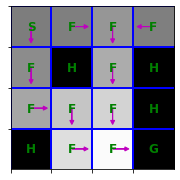

Terminated


In [22]:
mdp.reset()

policy = {s: np.random.choice(mdp.get_possible_actions(s)) 
             if not mdp.is_terminal(s) 
             else None
          for s in mdp.get_all_states()}

for i in range(50):
    clear_output(True)
    
    print("after iteration %i" % i)
    
    new_state_values, policy = policy_iteration(
        mdp, 
        policy=policy, 
        gamma=gamma, 
        num_iter=1, 
        min_difference=min_difference)
    
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    state_values = new_state_values
    
    draw_policy(mdp, state_values)
    
    sleep(0.15)
    
    if diff < min_difference:
        print("Terminated")
        break

### Big lake

In [23]:
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.2)

#### VI

after iteration 29
iter    0   |   diff: 0.00007   |   V(start): 0.141 


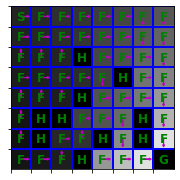

Terminated


In [24]:
mdp.reset()

min_difference = 1e-4

state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(50):
    clear_output(True)
    
    print("after iteration %i" % i)
    new_state_values = value_iteration(mdp, state_values, num_iter=1)
    
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    state_values = new_state_values
    
    draw_policy(mdp, state_values)
    
    sleep(0.15)
    
    if diff < min_difference:
        print("Terminated")
        break
# please ignore iter 0 at each step

#### PI

after iteration 7
iter    0   |   diff: 0.00000   |   V((0, 0)) = 0.141   V((0, 1)) = 0.161   V((0, 2)) = 0.184   V((0, 3)) = 0.210   V((0, 4)) = 0.240   V((0, 5)) = 0.270   V((0, 6)) = 0.304   V((0, 7)) = 0.337   V((1, 0)) = 0.136   V((1, 1)) = 0.156   V((1, 2)) = 0.179   V((1, 3)) = 0.208   V((1, 4)) = 0.263   V((1, 5)) = 0.301   V((1, 6)) = 0.346   V((1, 7)) = 0.388   V((2, 0)) = 0.121   V((2, 1)) = 0.136   V((2, 2)) = 0.141   V((2, 3)) = 0.000   V((2, 4)) = 0.270   V((2, 5)) = 0.311   V((2, 6)) = 0.394   V((2, 7)) = 0.448   V((3, 0)) = 0.115   V((3, 1)) = 0.132   V((3, 2)) = 0.152   V((3, 3)) = 0.179   V((3, 4)) = 0.249   V((3, 5)) = 0.000   V((3, 6)) = 0.450   V((3, 7)) = 0.517   V((4, 0)) = 0.103   V((4, 1)) = 0.115   V((4, 2)) = 0.120   V((4, 3)) = 0.000   V((4, 4)) = 0.323   V((4, 5)) = 0.376   V((4, 6)) = 0.470   V((4, 7)) = 0.597   V((5, 0)) = 0.081   V((5, 1)) = 0.000   V((5, 2)) = 0.000   V((5, 3)) = 0.255   V((5, 4)) = 0.330   V((5, 5)) = 0.418   V((5, 6)) = 0.000   V((5, 

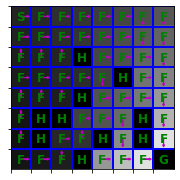

Terminated


In [25]:
mdp.reset()

policy = {s: np.random.choice(mdp.get_possible_actions(s)) 
             if not mdp.is_terminal(s) 
             else None
          for s in mdp.get_all_states()}

for i in range(50):
    clear_output(True)
    
    print("after iteration %i" % i)
    
    new_state_values, policy = policy_iteration(
        mdp, 
        policy=policy, 
        gamma=gamma, 
        num_iter=1, 
        min_difference=min_difference)
    
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    state_values = new_state_values
    
    draw_policy(mdp, state_values)
    
    sleep(0.15)
    
    if diff < min_difference:
        print("Terminated")
        break